In [3]:
import glob
import pandas as pd
import email
from email import policy
from src.parser.MailTextParser import parse_mime_tree
from src.parser.MailSubjectParser import parse_mime_subject
from src.parser.MailSenderParser import parse_mime_sender
from typing import Dict, List, Optional, Tuple, Union
from collections import Counter
import re

## TODO

4. TEXT ANALYSIS (cleaning first)

## Helper stuff


In [5]:
MONTH_MAPPING = {
    "01": "JAN",
    "02": "FEB",
    "03": "MAR",
    "04": "APR",
    "05": "MAI",
    "06": "JUN",
    "07": "JUL",
    "08": "AUG",
    "09": "SEP",
    "10": "OCT",
    "11": "NOV",
    "12": "DEC"
}

In [6]:
def guess_encoding(file_path):
    encodings = ['utf-8', 'iso-8859-1', 'windows-1252']  # Add more as needed
    for enc in encodings:
        try:
            with open(file_path, encoding=enc) as file:
                content = file.read()
                if content == None:
                    print("NONE")
                return enc
        except UnicodeDecodeError:
            continue
    print(f"Could not open {file_path}. Maybe wrong encoding?")
    return None

## MAIN FUNCTIONS

In [7]:
def get_emails_from_folder(year_range: Tuple[int,int]) -> Dict[int, Dict[str, Dict[int, email.message.Message]]]:
    '''Get all emails from email folders stored under data/.

        Parameters
        ----------
            year_range: Tuple(int,int)
                The year range, where starting year is _inclusive_ and end year is _exclusive_.

        Returns
        -------
            (Dict) 
            
            {
                YEAR: {
                    MONTH: {
                        1: <email.message.Message>
                    }
                    ...
                }
            }
    '''
    emails = dict()
    counter = 0
    for year in range(year_range[0],year_range[1]):
        emails[year] = dict()
        for month in MONTH_MAPPING:
            emails[year][month] = dict()
            for idx, file in enumerate(glob.glob(f"data/{year}/yggdrasill_{year}-{month}/*")):
                # guess encoding first, since there are quite a few non-UTF-8 mails
                enc = guess_encoding(file)
                with open(file, "r", encoding=enc) as f:
                    emails[year][month][idx] = email.message_from_file(f, policy=policy.default) # the policy-default is very important for subject titles
                    # check if message has been parsed correctly
                    if emails[year][month][idx].keys() == []:
                        print(f"Issue with mail!")
                        print(file)                            
                counter += 1
    print(f"Received {counter} emails from {year_range[0]} to {year_range[1]-1}.") 
    return emails

In [5]:
#emails = get_emails_from_folder((1997,2024))

## save emails
import pickle

with open("storage.pkl", "wb") as f:
    pickle.dump(emails, f)

In [8]:
import pickle

with open("storage.pkl", "rb") as f:
    emails = pickle.load(f)

In [7]:
#emails

In [12]:
def get_content_from_emails(email_dict: Dict[int, Dict[str, Dict[int, email.message.Message]]]) -> Dict:
    '''Extract CONTENT, SUBJECT, SENDER from emails retrieved via get_emails_from_folder().

        Parameters
        ----------
            email_dict: Dict[str, Dict[str, Dict[int, email.message.Message]]
                The dictionary with emails, retrieved using get_emails_from_folder().

        Returns
        -------
            (Dict) 
            
            {
                YEAR: {
                    MONTH: {
                        1: {
                            "subject": "<SUBJECT>",
                            "text": "<TEXT>",
                            "sender": "<SENDER>"
                        }
                        ...
                        "counter": <INT>
                    }
                    ...
                    "counter": <INT>
                }
                "counter": <INT>
            }
    '''
    emails = dict()
    counter = 0
    for year in email_dict:
        counter_year = 0
        emails[year] = dict()
        for month in email_dict[year]:
            counter_month = 0
            emails[year][month] = dict()
            for idx, mail in email_dict[year][month].items():
                text = parse_mime_tree(mail)
                sender = parse_mime_sender(mail)
                subject = parse_mime_subject(mail)
                emails[year][month][idx] = {
                    "text": text,
                    "subject": subject,
                    "sender": sender
                }
                # incrementing counters
                counter += 1
                counter_year += 1
                counter_month += 1
            emails[year][month]["counter"] = counter_month
        emails[year]["counter"] = counter_year
    emails["counter"] = counter
    return emails

In [13]:
content = get_content_from_emails(emails)

/mnt/c/Users/pyris/OneDrive/Dokumente/Projekte/Artikel/2024_Yggdrasil_Artikel/src/parser/MailTextParser.py:42: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  return BeautifulSoup(content, "html.parser").get_text() # removing html tags and noise
/mnt/c/Users/pyris/OneDrive/Dokumente/Projekte/Artikel/2024_Yggdrasil_Artikel/src/parser/MailTextParser.py:42: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  return BeautifulSoup(content, "html.parser").get_text() # removing html tags and noise


## Testing

### Analysis "subject" field

In [14]:
def clean_subject(subject: str) -> str:
    '''Function to clean an email-subject using RE.
    '''
    CLEANING_PATTERN = re.compile(r"^re:\s+\[ygg\]|^fwd:\s+\[ygg\]|^aw:\s+\[ygg\]|^re:\s+fwd:\s+\[ygg\]|^\[ygg\]|\baw:|\bfwd:|\bfw:|\bre:", re.IGNORECASE)
    subject = re.sub(CLEANING_PATTERN, " ", subject)
    subject = re.sub(r"\s{2,}", " ", subject)
    subject = subject.strip().lower()
    return subject

In [15]:
## get titles related to conferences and cfps

def get_specific_subjects(emails_in, pattern) -> Dict[int, Dict[str,Union[List,int]]]:
    '''Function to count and collect all subjects matching a RE pattern.

        Parameters
        ----------
            emails_in: Dict[]
                The nested content dict from get_content_from_emails().
            pattern: re
                The RE to match.

        Returns
        -------
            Dictionary:
            {
                <YEAR>: {
                    "titles": List[str],
                    "counter": int
                }
            }
    '''
    cfp_dict = dict()
    for year,months in emails_in.items():
        if type(year) == int:
            cfp_dict[year] = {
                "titles": list(),
                "counter": 0
            }
            for month,messages in months.items():
                if month != "counter":
                    for _,msg in messages.items():
                        if _ != "counter":
                            cln_subject = clean_subject(msg["subject"]) if msg["subject"] else ""
                            if re.match(pattern, cln_subject):
                                cfp_dict[year]["titles"].append(msg["subject"])
                                cfp_dict[year]["counter"] += 1
    return cfp_dict
                    
                

In [16]:
## get titles related to conferences and cfps

def get_top_subjects(emails_in) -> Counter:
    '''Function to count and collect all subjects.

        Parameters
        ----------
            emails_in: Dict[]
                The nested content dict from get_content_from_emails().

        Returns
        -------
            Counter: Counter() object with frequency of cleaned subjects.
    '''
    counter = Counter()
    for year,months in emails_in.items():
        if type(year) == int:
            for month,messages in months.items():
                if month != "counter":
                    for _,msg in messages.items():
                        if _ != "counter":
                            cln_subject = clean_subject(msg["subject"]) if msg["subject"] else ""
                            counter[cln_subject] += 1

    # remove empty subject lines
    if "" in counter:
        del counter[""]
    return counter
                    
                

In [17]:
CFP_RE_PATTERN = re.compile(r"cfa|cfp|konferenz|conference|call for paper(s)?|tagung")
ANNOUNCEMENTS_RE_PATTERN = re.compile(r"ankündigung|publikation|bekanntmachung")

spec_subjects_dict = get_specific_subjects(content, CFP_RE_PATTERN)

In [18]:
top_subjects = get_top_subjects(content)

In [19]:
top_subjects.most_common(5)

[('geschichte der religionswissenschaft', 83),
 ('heute vor 120 jahren ...', 74),
 ('diskriminierung von religionswissenschaftlerinnen? - vorschlag', 70),
 ('easr code of conduct', 70),
 ('religionswissenschaft', 68)]

### Analysis "author" field

In [20]:
def clean_sender(sender: str) -> str:
    '''Function to clean an email-from field using RE.
    '''
    SEARCH_PATTERN = re.compile(r"\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b", re.IGNORECASE)
    sender_clean = re.findall(SEARCH_PATTERN, sender)
    sender_clean = sender_clean[0].strip().lower() if len(sender_clean) > 0 else ""
    if sender_clean == "yggdrasill@lists.uni-marburg.de":
        # if the sender was the mailing list, try and find the name of the sender instead of email
        sender_clean = re.findall(r'^.*?[(<]', sender)
        sender_clean = sender_clean[0].strip().lower() if len(sender_clean) > 0 else ""
        sender_clean = re.sub(r"\W+", " ", sender_clean)
        sender_clean = re.sub(r"\s{2,}", " ", sender_clean)
    return sender_clean.strip()

In [21]:
def get_top_sender(emails_in) -> Counter:
    '''Function to count and collect sender.

        Parameters
        ----------
            emails_in: Dict[]
                The nested content dict from get_content_from_emails().

        Returns
        -------
            Counter: Counter() object with frequency of cleaned sender data.
    '''
    counter = Counter()
    for year,months in emails_in.items():
        if type(year) == int:
            for month,messages in months.items():
                if month != "counter":
                    for _,msg in messages.items():
                        if _ != "counter":
                            cln_sender = clean_sender(msg["sender"]) if msg["sender"] else ""
                            counter[cln_sender] += 1
    return counter
                    
                

In [22]:
sender_counter = get_top_sender(content)

In [23]:
sender_counter.most_common(10)

[('michael.a.schmiedel@gmx.de', 750),
 ('pye@staff.uni-marburg.de', 615),
 ('arabella.unger@vodafone.de', 538),
 ('giovannicasadio@libero.it', 387),
 ('perry.sl@btinternet.com', 352),
 ('christoph.bochinger@uni-bayreuth.de', 298),
 ('pye@mailer.uni-marburg.de', 246),
 ('mhutter@uni-bonn.de', 242),
 ('c.kleine@uni-leipzig.de', 206),
 ('carrope@gmx.de', 188)]

### Visualization

In [42]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Create a line plot with enhanced styling
sns.set_style("whitegrid")  # Set the background style
sns.set_palette("viridis")  # Set the color palette

def plot_posts_per_year(emails):
    '''Function to plot the number of posts per year.
    
    '''
    dict_ = dict()
    for year,data in emails.items():
        if type(year) == int:
            dict_[str(year)] = data["counter"]
    df = pd.DataFrame(dict_.items(), columns=["Year", "Posts"])
    sns.lineplot(x=df["Year"], y=df["Posts"], marker='o', markersize=8, linestyle='-', linewidth=2)
    plt.title(f"Posts per Year", fontsize=16)
    plt.xlabel("Year", fontsize=13)
    plt.xticks(rotation=45)
    plt.ylabel("Posts", fontsize=13)
    plt.tight_layout()
    plt.savefig(f"yearly_stats.png")
    

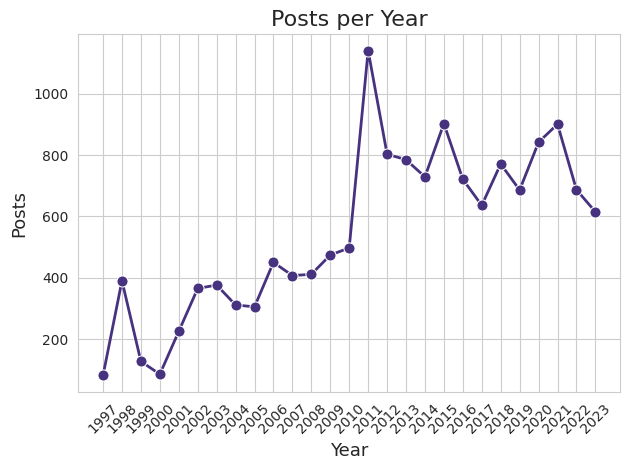

In [43]:
plot_posts_per_year(content)

In [40]:
def plot_posts_in_year(emails, year: int):
    '''Function to plot the number of posts/month of a particular year.
    
    '''
    dict_ = dict()
    for month,data in emails[year].items():
        if month != "counter":
            dict_[MONTH_MAPPING[month]] = data["counter"]
    df = pd.DataFrame(dict_.items(), columns=["Month", "Posts"])
    sns.lineplot(x=df["Month"], y=df["Posts"], marker='o', markersize=8, linestyle='-', linewidth=2)
    plt.title(f"Posts in {year}", fontsize=16)
    plt.xlabel("Month", fontsize=13)
    plt.xticks(rotation=45)
    plt.ylabel("Posts", fontsize=13)
    plt.tight_layout()
    plt.savefig(f"posts_in_{year}.png")
    

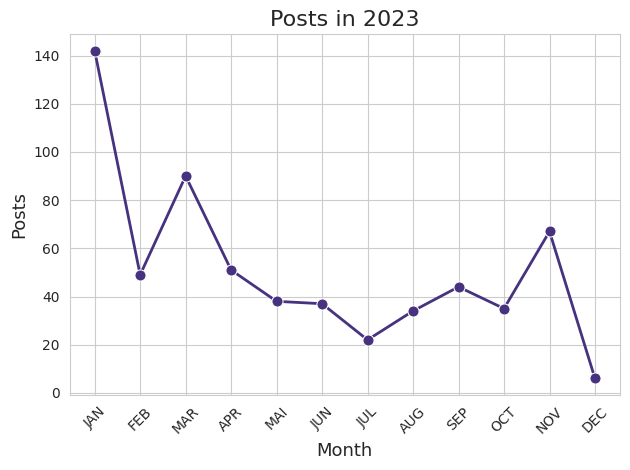

In [41]:
plot_posts_in_year(content,2023)